# Test 15

_Quench + Rotation_

The goal of this file is to compute the GS for several angles using MD.

**Simulation with LAMMPS**

Simulations are done by a Ramp (8mT/60s) + Evolution (60s) scheme


**Chirality**

Compute the chirality of the final states for all angles.

$$
    \Phi = \sum_{i,j} (-1)^{i+j}\chi_{ij}
$$

**Charge ordering**

Compute a complementary order parameter with topological charqes

$$
    \kappa = \sum_{i,j} (-1)^{i+j}q_{ij}
$$

**Averaging**
From all the datasets, compute $\langle |\Phi|\rangle$ and $\langle |\kappa|\rangle$, as well as $\sigma_\Phi$ and $\sigma_\kappa$.

In [1]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib as mpl 
#mpl.use('pgf')
import matplotlib.pyplot as plt

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice

import auxiliary as aux
import montecarlo_tools as mc
import chirality_tools as chir
ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

/home/leogabac/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# MD Simulations

This part only generates the datasets to work with for all angles.

In [12]:
quench_time = 120*ureg.s
rotation_time = 300*ureg.s
total_time = quench_time + rotation_time
data_path = "../data/test15/"
runs = 10

params = {
    "particle_radius":1.4*ureg.um,
    "particle_susceptibility":0.4,
    "particle_diffusion":0.14*ureg.um**2/ureg.s,
    "particle_temperature":300*ureg.K,
    "particle_density":1000*ureg.kg/ureg.m**3,

    "trap_sep":3*ureg.um,
    "trap_height":8*ureg.pN*ureg.nm,
    "trap_stiffness":10e-3*ureg.pN/ureg.nm,
    "height_spread":0,
    "susceptibility_spread":0,
    "isperiodic":True,

    "total_time":total_time,
    "framespersec":20*ureg.Hz,
    "dt":1*ureg.ms,
    "max_field":5*ureg.mT,
    "sim_temp":300*ureg.K,
    "sim_dipole_cutoff":40*ureg.um,
}

params["lattice_constant"] = params["trap_sep"]+(2*params["particle_radius"]+1*ureg.um)*np.sqrt(2)
params["size"] = 10

#locals().update(params)

In [13]:
def get_md_colloid(params,realization):
    sp = ice.spins()
    
    N = params["size"]
    a = params["lattice_constant"]
    
    # Create simulation objects
    sp.create_lattice("square",[N,N],lattice_constant=a, border="periodic")

    particle = ice.particle(radius = params["particle_radius"],
                susceptibility = params["particle_susceptibility"],
                diffusion = params["particle_diffusion"],
                temperature = params["particle_temperature"],
                density = params["particle_density"])

    trap = ice.trap(trap_sep = params["trap_sep"],
                height = params["trap_height"],
                stiffness = params["trap_stiffness"])

    col = ice.colloidal_ice(sp, particle, trap,
                            height_spread = params["height_spread"], 
                            susceptibility_spread = params["susceptibility_spread"],
                            periodic = params["isperiodic"])

        
    col.randomize()
    col.region = np.array([[0,0,-3*(params["particle_radius"]/a/N).magnitude],[1,1,3*(params["particle_radius"]/a/N).magnitude]])*N*a


    world = ice.world(
            field = params["max_field"],
            temperature = params["sim_temp"],
            dipole_cutoff = params["sim_dipole_cutoff"],
            boundaries=['p', 'p', 'p'])


    col.simulation(world,
                name = f"./lammps_files/test{realization}",
                include_timestamp = False,
                targetdir = r".",
                framerate = params["framespersec"],
                timestep = params["dt"],
                run_time = params["total_time"],
                output = ["x","y","z","mux","muy","muz"],
                processors=1)

    # Field
    

    col.sim.field.fieldx = "v_Bmag*sin(PI/2/300*(time-120e6)/1e6)*(time>=120e6)"
    col.sim.field.fieldy = "0"
    col.sim.field.fieldz = "v_Bmag/120e6*time*(time<120e6)+v_Bmag*cos(PI/2/300*(time-120e6)/1e6)*(time>=120e6)"        
        
    col.run_simulation()

    col.load_simulation()

    return col

In [14]:
def jesus_take_the_wheels(params,data_path,realization):
    trj_path = data_path + "/trj/"
    ctrj_path = data_path + "/ctrj/"

    try:
        os.mkdir(trj_path)
        os.mkdir(ctrj_path)
    except:
        pass
    
    col = get_md_colloid(params,realization)

    filename = f"trj{realization}.csv"
    col.trj.to_csv(trj_path + filename)

    filename = f"ctrj{realization}.csv"
    trj = ice.get_ice_trj(col.trj, bounds = col.bnd)
    trj.to_csv(ctrj_path + filename)
    
    return None

# MD Sims

This block checks which angles are going to be ran. Helps for running by batches.

In [6]:
import concurrent.futures

In [ ]:
runs = 10
data_path = "../data/test15"
realizations = list(range(1,runs+1))
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    # map the function to the realizations
    results = list(
        executor.map(
            jesus_take_the_wheels,
            [params] * len(realizations),
            [data_path] * len(realizations),
            realizations,
        )
    )

This section graphs the fields just to check that everything is OK.

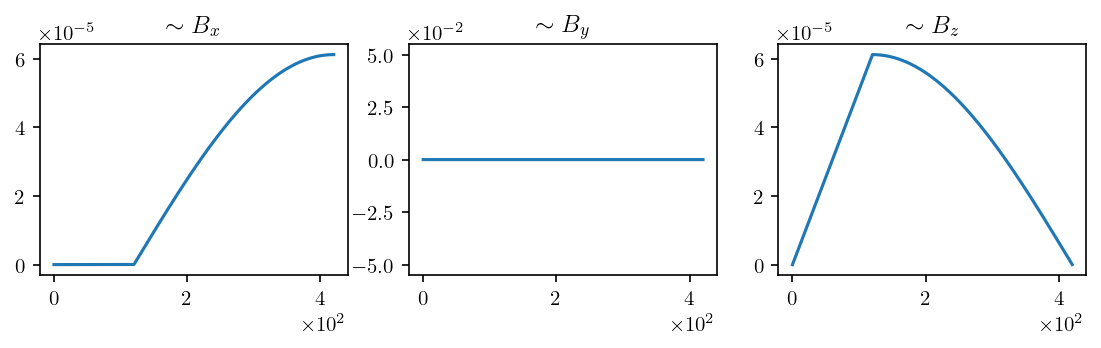

In [127]:
trj_raw = trj = pd.read_csv("../data/test15/trj/trj1.csv", index_col=[0,1])
ctrj_raw = pd.read_csv("../data/test15/ctrj/ctrj1.csv", index_col=[0,1])

fig, axes = plt.subplots(1,3,figsize=(9,2),dpi=150)

ax = axes[0]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"mux"]))
ax.set_title("$\\sim B_x$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

ax = axes[1]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muy"]))
ax.set_title("$\\sim B_y$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

ax = axes[2]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muz"]))
ax.set_title("$\\sim B_z$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

plt.show()

# Chirality

This section deals with chirality computations for all angles. \
Check the _chirality_tools.py_ for more information.

In [8]:
# General information

particle = ice.particle(radius = params["particle_radius"],
            susceptibility = params["particle_susceptibility"],
            diffusion = params["particle_diffusion"],
            temperature = params["particle_temperature"],
            density = params["particle_density"])

trap = ice.trap(trap_sep = params["trap_sep"],
            height = params["trap_height"],
            stiffness = params["trap_stiffness"])


params["particle"] = particle
params["trap"] = trap


Getting the analysis frames

In [44]:
quench_time = 120*ureg.s 
initial_frame = (params['framespersec'] * quench_time).magnitude
last_frame = trj_raw.index.get_level_values("frame").unique()[-1]
analysis_frames = list(range(initial_frame,last_frame+1,1))
framestodo = analysis_frames[::200]
len(framestodo)


30

In [ ]:
phi = []
runs = 10

data_path = '../data/test15/'

for frame in tqdm(framestodo):

    angle_chirs = [chir.get_chirality_on_realization2(params,data_path,i,sel_frame=frame) for i in range(1,runs+1)]

    phi.append(angle_chirs)

phi

In [46]:
cols = ['frame'] + [str(i) for i in range(runs)]
npframe = np.array(framestodo).reshape(-1,1)

In [ ]:
phi_df = pd.DataFrame(phi,columns = [str(i) for i in range(runs)])
phi_df['frame'] = npframe
phi_df.to_csv(f"{data_path}/chirality.csv")
phi_df

In [ ]:
phi_df.applymap(np.abs).mean(axis=1)

# Complementary order parameter

$$
    Q = \sum_{i,j} (-1)^{i+j}q_{ij}
$$

In [18]:
i=5
os.path.join(data_path,"trj",f"trj{i}.csv")

'../data/test15/trj/trj5.csv'

In [ ]:
trj_path = os.path.join(data_path,"trj")
ctrj_path = os.path.join(data_path,"ctrj")
vrt_path = os.path.join(data_path,"vertices")

# Get the number of realizations
_, _, files = next(os.walk(trj_path))
realizations = len(files)

for i in range(1,realizations+1):
    print("========================================")
    print(f"Working on realization {i}")

    # Importing files
    trj_file = os.path.join(trj_path,f"trj{i}.csv")
    print(f"Opening " + trj_file)
    ctrj_file = os.path.join(ctrj_path,f"ctrj{i}.csv")
    print(f"Opening " + ctrj_file)
    trj_raw = trj = pd.read_csv(trj_file, index_col=[0,1])
    ctrj_raw = pd.read_csv(ctrj_file, index_col=[0,1])

    # Doing shit with the vertices
    v = ice.vertices()
    frames = ctrj_raw.index.get_level_values("frame").unique()

    vrt_file = os.path.join(vrt_path,f"vertices{i}.csv")
    v.trj_to_vertices(ctrj_raw.loc[frames[::5]])

    print(f"Saving vertices to " + vrt_file)
    v.vertices.to_csv(vrt_file)
    
    clear_output(wait=True)

In [62]:
vrt_df = pd.read_csv(os.path.join(data_path,"vertices","vertices1.csv"), index_col=[0,1] )
vrt_frames = vrt_df.index.get_level_values("frame").unique().to_list()
analysis_frames = [frame for frame in vrt_frames if frame > initial_frame][::5]
analysis_frames


[2405,
 2430,
 2455,
 2480,
 2505,
 2530,
 2555,
 2580,
 2605,
 2630,
 2655,
 2680,
 2705,
 2730,
 2755,
 2780,
 2805,
 2830,
 2855,
 2880,
 2905,
 2930,
 2955,
 2980,
 3005,
 3030,
 3055,
 3080,
 3105,
 3130,
 3155,
 3180,
 3205,
 3230,
 3255,
 3280,
 3305,
 3330,
 3355,
 3380,
 3405,
 3430,
 3455,
 3480,
 3505,
 3530,
 3555,
 3580,
 3605,
 3630,
 3655,
 3680,
 3705,
 3730,
 3755,
 3780,
 3805,
 3830,
 3855,
 3880,
 3905,
 3930,
 3955,
 3980,
 4005,
 4030,
 4055,
 4080,
 4105,
 4130,
 4155,
 4180,
 4205,
 4230,
 4255,
 4280,
 4305,
 4330,
 4355,
 4380,
 4405,
 4430,
 4455,
 4480,
 4505,
 4530,
 4555,
 4580,
 4605,
 4630,
 4655,
 4680,
 4705,
 4730,
 4755,
 4780,
 4805,
 4830,
 4855,
 4880,
 4905,
 4930,
 4955,
 4980,
 5005,
 5030,
 5055,
 5080,
 5105,
 5130,
 5155,
 5180,
 5205,
 5230,
 5255,
 5280,
 5305,
 5330,
 5355,
 5380,
 5405,
 5430,
 5455,
 5480,
 5505,
 5530,
 5555,
 5580,
 5605,
 5630,
 5655,
 5680,
 5705,
 5730,
 5755,
 5780,
 5805,
 5830,
 5855,
 5880,
 5905,
 5930,
 5955,

In [60]:
chir.get_charge_order_on_frame_on_realization(params,data_path,cur_frame,1,tol=1.6)

-4.0

In [63]:
psi= []
for frame in tqdm(analysis_frames):
    results = [chir.get_charge_order_on_frame_on_realization(params,data_path,frame,realization,tol=1.6) for realization in range(1,runs+1) ]
    psi.append(results)

  0%|          | 0/240 [00:00<?, ?it/s]

100%|██████████| 240/240 [06:04<00:00,  1.52s/it]


In [78]:
psi_df = pd.DataFrame(psi, columns=[str(i) for i in range(runs)])
psi_df["frame"] = np.array(analysis_frames).reshape(-1,1)
psi_df.to_csv(os.path.join(data_path,"charges.csv"))

,0,1,2,3,4,5,6,7,8,9,frame
0,-4.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.0,2405
1,12.0,-4.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2430
2,12.0,2.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,-24.0,2455
3,8.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,-14.0,2480
4,20.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.0,2505
...,...,...,...,...,...,...,...,...,...,...,...
235,-16.0,14.0,-18.0,184.0,136.0,212.0,156.0,-144.0,-166.0,16.0,8280
236,-16.0,14.0,-18.0,184.0,136.0,212.0,160.0,-140.0,-162.0,12.0,8305
237,-14.0,14.0,-18.0,184.0,136.0,212.0,156.0,-136.0,-162.0,14.0,8330
238,-16.0,18.0,-18.0,184.0,136.0,212.0,156.0,-140.0,-158.0,18.0,8355


#  Importing data and plotting

In [90]:
phi_df = pd.read_csv(os.path.join(data_path,"chirality.csv"),index_col=0).applymap(np.abs)
chir_angle = 90/300 * (  phi_df["frame"]/params["framespersec"].magnitude - quench_time.magnitude )

psi_df = pd.read_csv(os.path.join(data_path,"charges.csv"),index_col=0).applymap(np.abs)
charge_angle = 90/300 * (  psi_df["frame"]/params["framespersec"].magnitude - quench_time.magnitude )

datacols = [str(i) for i in range(runs)]
datacols

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [93]:
phi_means = phi_df[datacols].mean(axis=1).to_numpy()
phi_sigmas = phi_df[datacols].std(axis=1).to_numpy()

psi_means = psi_df[datacols].mean(axis=1).to_numpy()
psi_sigmas = psi_df[datacols].std(axis=1).to_numpy()


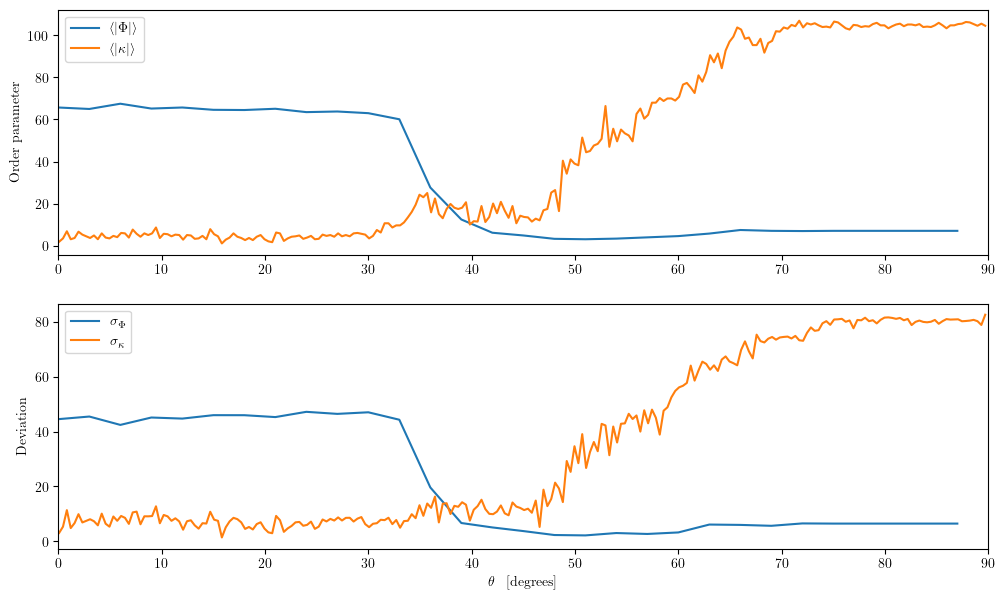

In [95]:
fig, axes = plt.subplots(2,1,figsize=(12,7))

ax = axes[0]
ax.plot(chir_angle,phi_means, label = "$\\langle |\\Phi|\\rangle$")
ax.plot(charge_angle,psi_means, label = "$\\langle |\\kappa|\\rangle$")
ax.set_ylabel("Order parameter")
ax.set_xlim(0,90)
ax.legend()

ax = axes[1]

ax.plot(chir_angle,phi_sigmas, label="$\\sigma_\\Phi$")
ax.plot(charge_angle,psi_sigmas, label="$\\sigma_\\kappa$")

ax.set_xlabel("$\\theta$ \, [degrees]")
ax.set_ylabel("Deviation")

ax.legend()

ax.set_xlim(0,90)

plt.show()

fig.savefig("../data/test12/order_parameters.png",dpi=300)
fig.savefig("../data/test12/order_parameters.pdf")

# Visualizing some shit

In [99]:
region_limit = np.round( params["lattice_constant"].magnitude * params["size"] )
region_limit

84.0

In [118]:
trj = pd.read_csv(os.path.join(data_path,"trj","trj9.csv"), index_col=[0,1]).drop(columns={'type','t'})
ctrj = pd.read_csv(os.path.join(data_path,"ctrj","ctrj9.csv"), index_col=[0,1]).drop(columns={'type','t'})
ctrj_sel = ctrj.loc[last_frame,:]
v = ice.vertices()
v = v.trj_to_vertices(ctrj_sel)

100%|██████████| 200/200 [00:01<00:00, 113.00it/s]


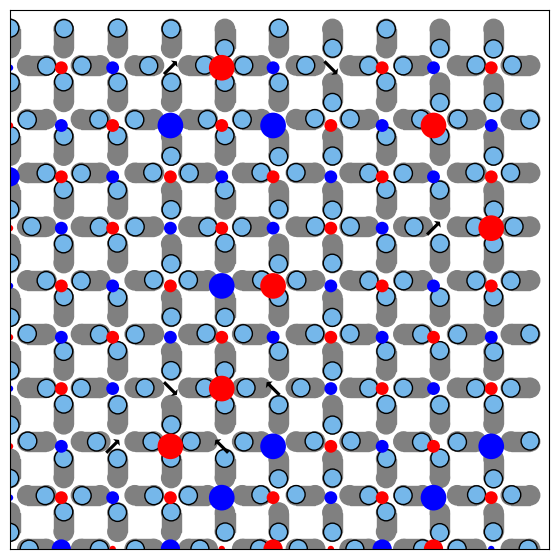

In [119]:
fig, ax = plt.subplots(figsize=(7,7))
ice.draw_frame(ctrj,
               region=[0,region_limit,0,region_limit],
               radius=params["particle_radius"].magnitude,
               cutoff=params["trap_sep"].magnitude/2,
               particle_color='#75b7ea',
               trap_color='gray',
               ax = ax)

v.display(ax,dpl_scale=0.5,dpl_width=2.5,circle_scale=0.5)
plt.show()

# Vertex counting

In [123]:
vrt_path = os.path.join(data_path,"vertices/")
vertices = aux.getVerticesDict(vrt_path)
counts = aux.getVerticesCount(vertices)
vrt_ts = aux.getVerticesAverage(counts,params["framespersec"])
types = vrt_ts.columns.to_list()[1:]
t = vrt_ts["time"].to_numpy()
vrt_counts = vrt_ts[types].to_numpy()

/home/leogabac/.local/lib/python3.8/site-packages/pandas/core/construction.py:580: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)


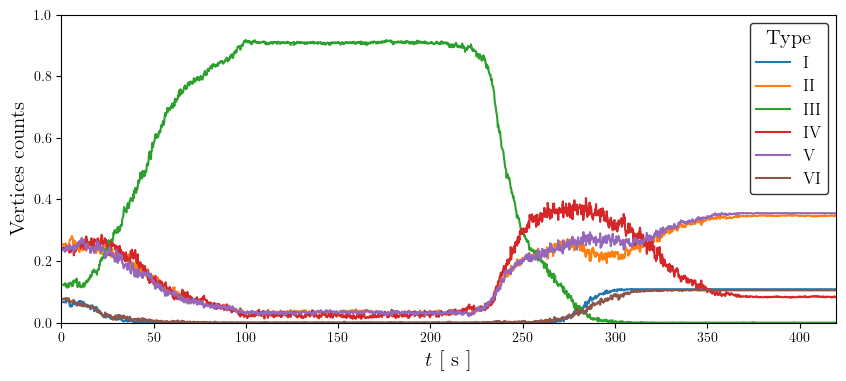

In [126]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(t,vrt_counts[:,0])
ax.plot(t,vrt_counts[:,1])
ax.plot(t,vrt_counts[:,2])
ax.plot(t,vrt_counts[:,3])
ax.plot(t,vrt_counts[:,4])
ax.plot(t,vrt_counts[:,5])

ax.legend(types, fontsize=12,title='Type', title_fontsize=15, edgecolor='black')
ax.set_xlabel("$t$  [ s ] ", fontsize=15)
ax.set_ylabel("Vertices counts", fontsize=15)
ax.set_xlim(0,420)
ax.set_ylim(0,1)
plt.show()

fig.savefig('../data/vertices_full.pdf', bbox_inches='tight')
fig.savefig('../data/vertices_full.jpeg', dpi=300)